# Bird Classifier

Here I will use the fastai library to implement an image recognition classifier that will predict the type of bird in an image. This requires the use of a GPU with a reasonable amount of memory. For this notebook I am using 1 GPU, with 64G of memory. 

In [1]:
%reload_ext autoreload
%autoreload 2 
%matplotlib inline

Import all packages from the fastai library, this enables a very practicle interface to [PyTorch](https://pytorch.org/).

In [228]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

## Explore and prepare the data

I will try out the [NABirds](http://birds.cornell.edu/nabirds/) dataset, published by the Cornell Lab of Ornithology in this [Van Horn et al. (2015)](https://vision.cornell.edu/se3/wp-content/uploads/2015/05/Horn_Building_a_Bird_2015_CVPR_paper.pdf). The data consists of 42,562 images of 555 categories of birds. The dataset is 9.21GB as a gzipped tar.

In [48]:
path = Path.ls(Path("data")); path

PosixPath('data/nabirds')

In [29]:
ut=str(path[0]);ut

'data/nabirds.tar.gz'

In [32]:
# !tar xvzf {ut} -C data

In [50]:
path[0].ls(); nabirds_path = path[0]

They provide lots of information here for all the images. We want to get these images into a DataBunch object, which is the way we will start using fastai with most datasets. 

In [66]:
path_img = nabirds_path/'images'
path_img

PosixPath('data/nabirds/images')

In [68]:
fnames = get_image_files(path_img, recurse=True)
fnames[:5]

[PosixPath('data/nabirds/images/0498/9842e2a86ea747b7a4f8e4732e5f960a.jpg'),
 PosixPath('data/nabirds/images/0498/b025b4b80573497ba474593cbd26cf68.jpg'),
 PosixPath('data/nabirds/images/0498/383391898ec34c8c9bb1179902d18666.jpg'),
 PosixPath('data/nabirds/images/0498/33198bbb63a34507855f391c69b72326.jpg'),
 PosixPath('data/nabirds/images/0498/47583747fb7a4e71a5215cd4a0340c8a.jpg')]

We have a bunch of files each file is nested in a directory that numerically represents one of 555 classes, ther are about 100 imags per class. So we need to write some functions to extract the image labels for each image. Some of these functions were already provided in `nabirds.py`

In [150]:
def load_class_names(dataset_path=''):

  names = {}

  with open(os.path.join(dataset_path, 'classes.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      class_id = pieces[0]
      names[class_id] = ' '.join(pieces[1:])

  return names

def load_image_labels(dataset_path=''):
  labels = {}

  with open(os.path.join(dataset_path, 'image_class_labels.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      class_id = pieces[1]
      labels[image_id] = class_id

  return labels


def load_image_paths(dataset_path='', path_prefix=''):

  paths = {}

  with open(os.path.join(dataset_path, 'images.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      path = os.path.join(path_prefix, pieces[1])
      paths[image_id] = path

  return paths


def load_hierarchy(dataset_path=''):

  parents = {}

  with open(os.path.join(dataset_path, 'hierarchy.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      child_id, parent_id = pieces
      parents[child_id] = parent_id

  return parents


def load_photographers(dataset_path=''):

  photographers = {}
  with open(os.path.join(dataset_path, 'photographers.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      photographers[image_id] = ' '.join(pieces[1:])

  return photographers


def load_train_test_split(dataset_path=''):
  train_images = []
  test_images = []

  with open(os.path.join(dataset_path, 'train_test_split.txt')) as f:
    for line in f:
      pieces = line.strip().split()
      image_id = pieces[0]
      is_train = int(pieces[1])
      if is_train:
        train_images.append(image_id)
      else:
        test_images.append(image_id)

  return train_images, test_images

In [102]:
data_path = str(Path("data/nabirds")); data_path

'data/nabirds'

In [124]:
# get image classes (class_num, class)
class_names_dict = load_class_names(data_path)

list(class_names_dict.items())[0:5] # length 1011


[('0', 'Birds'),
 ('1', 'Ducks, Geese, and Swans'),
 ('2', 'Grouse, Quail, and Allies'),
 ('3', 'Loons'),
 ('4', 'Grebes')]

In [123]:
# get image labels (img, class_num)
image_labels_dict = load_image_labels(data_path)
list(image_labels_dict.items())[0:5] # length 48562

[('0000139e-21dc-4d0c-bfe1-4cae3c85c829', '817'),
 ('0000d9fc-4e02-4c06-a0af-a55cfb16b12b', '860'),
 ('00019306-9d83-4334-b255-a447742edce3', '900'),
 ('0001afd4-99a1-4a67-b940-d419413e23b3', '645'),
 ('000332b8-997c-4540-9647-2f0a8495aecf', '929')]

In [125]:
# get image hierarchy (idx, class_num)
image_hierarchy_list = load_hierarchy(data_path)
list(image_hierarchy_list.items())[100:105] # length 1010



[('101', '22'), ('102', '1'), ('103', '2'), ('104', '6'), ('105', '14')]

In [201]:
# get image labels
image_ids = load_image_paths(data_path)
i =0
for k in image_ids:
    if i < 10:
        print(class_names_dict[image_labels_dict[k]])
    i+=1

image_id_dict = defaultdict()
for k in list(image_ids.items()):
    image_id_dict[k[1]] = k[0]

Oak Titmouse
Ovenbird
Savannah Sparrow
Eared Grebe (Nonbreeding/juvenile)
Eastern Phoebe
Yellow-crowned Night-Heron (Immature)
Florida Scrub-Jay
Savannah Sparrow
Yellow-headed Blackbird (Female/Immature Male)
Herring Gull (Adult)


In [205]:
image_id_dict['0498/9842e2a86ea747b7a4f8e4732e5f960a.jpg']

'9842e2a8-6ea7-47b7-a4f8-e4732e5f960a'

Now write a function to get the labels frome the filenames. 

In [129]:
fnames[:5]

[PosixPath('data/nabirds/images/0498/9842e2a86ea747b7a4f8e4732e5f960a.jpg'),
 PosixPath('data/nabirds/images/0498/b025b4b80573497ba474593cbd26cf68.jpg'),
 PosixPath('data/nabirds/images/0498/383391898ec34c8c9bb1179902d18666.jpg'),
 PosixPath('data/nabirds/images/0498/33198bbb63a34507855f391c69b72326.jpg'),
 PosixPath('data/nabirds/images/0498/47583747fb7a4e71a5215cd4a0340c8a.jpg')]

In [209]:
def get_labels(file_path):
    path_parts = str(file_path).split("/")
    image = "/".join(path_parts[3:5])
    image_hash = image_id_dict[image]
    label = class_names_dict[image_labels_dict[image_hash]]
    return label
    
get_labels("data/nabirds/images/0498/47583747fb7a4e71a5215cd4a0340c8a.jpg")

'Crested Caracara'

Load the data into an image databunch, and size everything as 224x224. A combination of cropping and resizing is used by the fastai library to randomly size all the data to the same size. The data are then normalized by making the mean and standard deviation of the RGB channels to 0, and 1 respectively. 

In [215]:
data = ImageDataBunch.from_name_func(path_img, fnames, label_func=get_labels, size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (38850 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Crested Caracara,Crested Caracara,Crested Caracara,Crested Caracara,Crested Caracara
Path: data/nabirds/images;

Valid: LabelList (9712 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Tennessee Warbler,Vesper Sparrow,Ruby-throated Hummingbird (Female, immature),Golden-fronted Woodpecker,Northern Gannet (Adult, Subadult)
Path: data/nabirds/images;

Test: None

In [216]:
# how many classes? 
data.c

555

Good, this agrees with the number of classes the paper said it has! Let's look at some of the data and their labels.

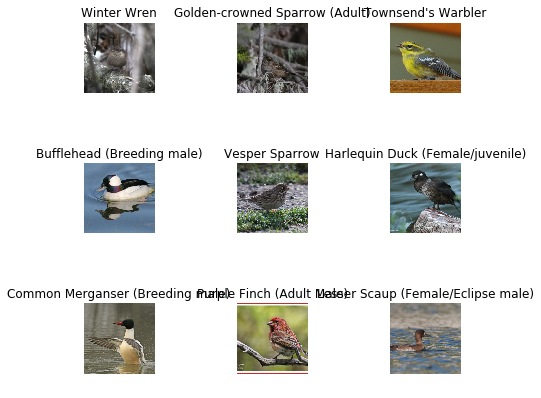

In [218]:
data.show_batch(rows=3, figsize=(7,6))

In [220]:
len(data.classes), data.c

(555, 555)

In [221]:
data.classes[0:5]

["Abert's Towhee",
 'Acorn Woodpecker',
 "Allen's Hummingbird (Adult Male)",
 "Allen's Hummingbird (Female, immature)",
 'American Avocet']

## Train the model

Use a convolutional neural network learner with a single hidden layer as a classifier. We will use the resnet34 architecture, just to try it out. resnet34 trains faster than a resnet50. This was already trained on imagenet, so we are really doing transfer learning on these birds. This means that we have a good starting place for the model, it's much faster, it can be used on less data, and it can with tweaking give better results. 

In [230]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate])

In [231]:
# fit the model using one_cycle, and 4 epochs
# fit one cycle is only training on the last layer
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.037581,2.314038,0.442545,0.557455,02:39
1,2.076877,1.614839,0.574032,0.425968,02:51
2,1.534899,1.349103,0.644255,0.355745,02:47
3,1.263913,1.290472,0.656199,0.343801,02:51


The last few layers of the model is accurately predicting the right bird 65% of the time!

Let's do some fine tuning and see how much accuracy we can squeeze out. 

In [240]:
learn.save("birds-1")

In [232]:
interp = ClassificationInterpretation.from_learner(learn)

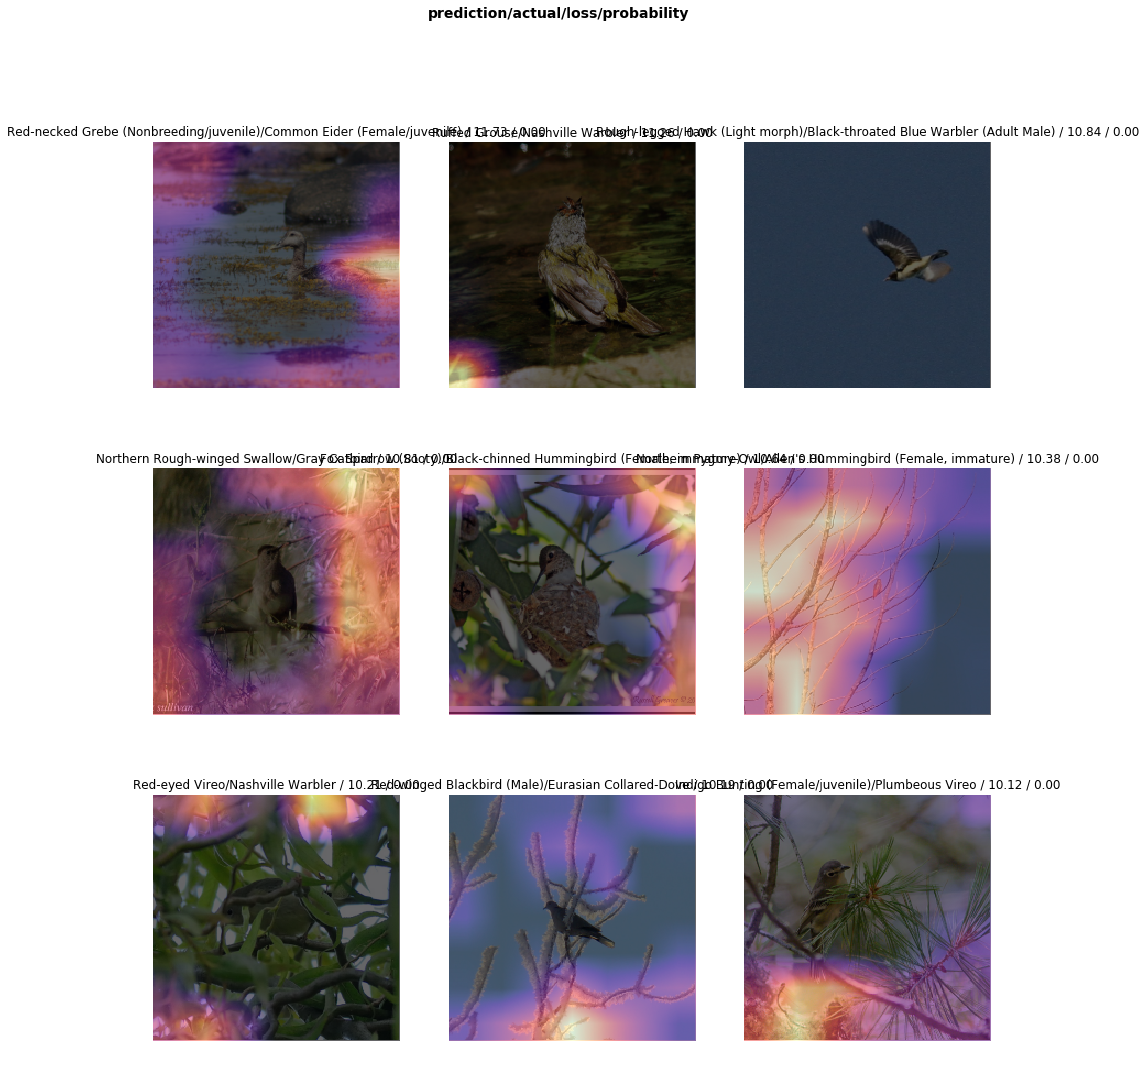

In [235]:
interp.plot_top_losses(9, figsize=(15,17))

In [238]:
interp.most_confused(min_val=2)

[('Western Grebe', "Clark's Grebe", 11),
 ('Downy Woodpecker', 'Hairy Woodpecker', 9),
 ('Western Gull (Immature)', 'Herring Gull (Immature)', 9),
 ('Black-capped Chickadee', 'Carolina Chickadee', 8),
 ('Eared Grebe (Nonbreeding/juvenile)',
  'Horned Grebe (Nonbreeding/juvenile)',
  8),
 ('Eastern Screech-Owl', 'Western Screech-Owl', 8),
 ('Eastern Wood-Pewee', 'Western Wood-Pewee', 8),
 ('Yellow-bellied Sapsucker', 'Red-naped Sapsucker', 8),
 ('Black-billed Cuckoo', 'Red-eyed Vireo', 7),
 ('Calliope Hummingbird (Female, immature)',
  'Black-chinned Hummingbird (Female, immature)',
  7),
 ("Barrow's Goldeneye (Breeding male)", 'Common Goldeneye (Breeding male)', 6),
 ('Black-chinned Hummingbird (Female, immature)',
  'Ruby-throated Hummingbird (Female, immature)',
  6),
 ('Caspian Tern', 'Common Tern', 6),
 ('Common Raven', 'American Crow', 6),
 ('Common Raven', 'Chihuahuan Raven', 6),
 ('Hairy Woodpecker', 'Downy Woodpecker', 6),
 ('Sharp-shinned Hawk (Immature)', "Cooper's Hawk (Imma

It looks like the most confused birds are at least in the same type of bird, it's just having a hard time discriminating between between tiny differences. 

These tiny differences, according to the top losses plot seem to be focusing on differences in tree branch looking features. 

So, the model is doing pretty good considering the specificity of the labels, it's now just trying to figure out the tree branches!

Let's now unfreeze, training the whole model. This will take a bit longer. 

In [242]:
learn.unfreeze()
learn.fit_one_cycle(6) # six epochs of training

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.941320,1.326325,0.648991,0.351009,02:50
1,1.422786,1.634545,0.578460,0.421540,02:55
2,1.001738,1.328920,0.652286,0.347714,02:54
3,0.517133,1.143961,0.707166,0.292834,02:50
4,0.161809,0.976539,0.754530,0.245470,02:50
5,0.065804,0.948789,0.761223,0.238777,02:51


After 20 minutes we are now at an accuracy of 76%, which is really getting there, it looks like we could go for at least 5 more epochs, but first let's look at the losses. 

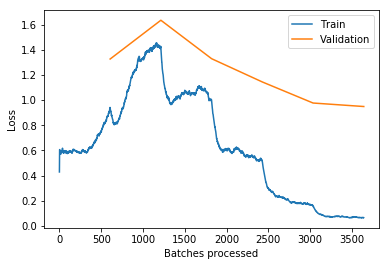

In [244]:
learn.recorder.plot_losses()

Our validation loss is still much higher than our training loss, it looks like we could still train for more epochs, but we could also adjust our learning rate. 

In [249]:
learn.load("birds-1")

Learner(data=ImageDataBunch;

Train: LabelList (38850 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Crested Caracara,Crested Caracara,Crested Caracara,Crested Caracara,Crested Caracara
Path: data/nabirds/images;

Valid: LabelList (9712 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Tennessee Warbler,Vesper Sparrow,Ruby-throated Hummingbird (Female, immature),Golden-fronted Woodpecker,Northern Gannet (Adult, Subadult)
Path: data/nabirds/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBloc

In [251]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


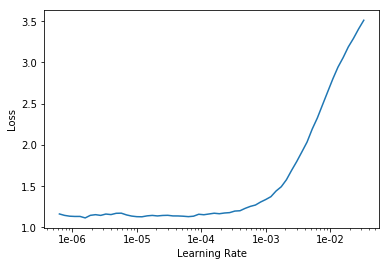

In [252]:
learn.recorder.plot()

Woah crazy, we are definitely going to want to tune the learning rate. The defualt learning rate used above, 1e-3, is where the loss starts increasing. We want the learning rate to be a number (or range of numbers) where the loss is not increasing, because remember the goal is to minimize the loss function. So, let's do that. 

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-5, 5e-4))

## Training using a resnet50

A resnet50 will use more layers, and this may or may not improve accuracy. Let's try it out.  